In [6]:
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
import matplotlib.pyplot as plt



## Zeitserie erstellen

In [7]:
def generate_time_eries(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  # Welle 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # Welle 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # Rauschen
    return series[..., np.newaxis].astype(np.float32)

In [8]:
n_steps = 50
series = generate_time_eries(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [9]:
# model = keras.models.Sequential([
#     keras.layers.Flatten(input=(50, 1)),
#     keras.layers.Dense(1)
# ])

# model.compile(loss="mse", optimizer="adam")
# model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))


### Das einfachste RNN das man bauen könnte

In [10]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

model.compile(loss="mse", optimizer="adam")
model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20


/Users/riccardo/Desktop/Github/Bachelor/Bachelor/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1476 - val_loss: 0.1423
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1396 - val_loss: 0.1422
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1395 - val_loss: 0.1416
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1382 - val_loss: 0.1415
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1379 - val_loss: 0.1422
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1398 - val_loss: 0.1430
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1439 - val_loss: 0.1428
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1390 - val_loss: 0.1419
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1401 - val_loss: 0.1420
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1406 - val_loss: 0.1420
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1403 - val_loss: 0.1412
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.

---------------------------------------------------------------------------

# Mehrere Zeitschritte vorhersagen

In [11]:
series = generate_time_eries(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

y_pred = X[:, n_steps:]




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


# Recurrent Neural Network

## Vorhersage des DAX Kurses

In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt

In [13]:
data = pd.read_csv("data/raw/^GDAXI.csv")
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1987-12-30,1005.190002,1005.190002,1005.190002,1005.190002,1005.190002,0.0
1,1987-12-31,NaN,NaN,NaN,NaN,NaN,NaN
2,1988-01-01,NaN,NaN,NaN,NaN,NaN,NaN
3,1988-01-04,956.489990,956.489990,956.489990,956.489990,956.489990,0.0
4,1988-01-05,996.099976,996.099976,996.099976,996.099976,996.099976,0.0


In [14]:
print(data.describe())
data.isna().sum()

               Open          High           Low         Close     Adj Close  \
count   9213.000000   9213.000000   9213.000000   9213.000000   9213.000000   
mean    6710.231490   6755.542185   6660.681012   6709.836470   6709.836470   
std     4387.626710   4411.600909   4362.377131   4387.967762   4387.967762   
min      936.000000    936.000000    936.000000    936.000000    936.000000   
25%     2821.320068   2850.939941   2786.610107   2820.810059   2820.810059   
50%     5812.810059   5869.220215   5761.299805   5814.740234   5814.740234   
75%     9905.669922   9978.940430   9836.459961   9920.919922   9920.919922   
max    18874.849609  18892.919922  18719.810547  18869.359375  18869.359375   

             Volume  
count  9.213000e+03  
mean   6.852572e+07  
std    6.247492e+07  
min    0.000000e+00  
25%    0.000000e+00  
50%    7.117340e+07  
75%    1.044807e+08  
max    5.101956e+08  


Date           0
Open         168
High         168
Low          168
Close        168
Adj Close    168
Volume       168
dtype: int64

In [15]:
data.isna().sum()
data = data.dropna()
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,1987-12-30,1005.190002,1005.190002,1005.190002,1005.190002,1005.190002,0.0
3,1988-01-04,956.489990,956.489990,956.489990,956.489990,956.489990,0.0
4,1988-01-05,996.099976,996.099976,996.099976,996.099976,996.099976,0.0
5,1988-01-06,1006.010010,1006.010010,1006.010010,1006.010010,1006.010010,0.0
6,1988-01-07,1014.469971,1014.469971,1014.469971,1014.469971,1014.469971,0.0
...,...,...,...,...,...,...,...
9376,2024-06-03,18503.789063,18697.089844,18503.789063,18608.160156,18608.160156,54181600.0
9377,2024-06-04,18608.300781,18608.300781,18365.529297,18405.640625,18405.640625,81414800.0
9378,2024-06-05,18406.060547,18624.359375,18406.060547,18575.939453,18575.939453,63882100.0
9379,2024-06-06,18576.580078,18784.650391,18576.580078,18652.669922,18652.669922,60878800.0


In [16]:
length_data = len(data)     # rows that data has
split_ratio = 0.7           # %70 train + %30 validation
length_train = round(length_data * split_ratio)  
length_validation = length_data - length_train
print("Data length :", length_data)
print("Train data length :", length_train)
print("Validation data lenth :", length_validation)

Data length : 9213
Train data length : 6449
Validation data lenth : 2764


In [17]:
train_data = data[:length_train].iloc[:,:2] 
train_data['Date'] = pd.to_datetime(train_data['Date'])  # converting to date time object
train_data

,Date,Open
0,1987-12-30,1005.190002
3,1988-01-04,956.489990
4,1988-01-05,996.099976
5,1988-01-06,1006.010010
6,1988-01-07,1014.469971
...,...,...
6607,2013-07-05,8010.439941
6608,2013-07-08,7865.919922
6609,2013-07-09,8021.129883
6610,2013-07-10,8056.509766


In [52]:
length_train

6449

In [18]:
validation_data = data[length_train:].iloc[:,:2]
validation_data['Date'] = pd.to_datetime(validation_data['Date'])  # converting to date time object
validation_data

,Date,Open
6612,2013-07-12,8192.910156
6613,2013-07-15,8237.919922
6614,2013-07-16,8251.509766
6615,2013-07-17,8216.700195
6616,2013-07-18,8239.379883
...,...,...
9376,2024-06-03,18503.789063
9377,2024-06-04,18608.300781
9378,2024-06-05,18406.060547
9379,2024-06-06,18576.580078


In [19]:
dataset_train = train_data.Open.values
dataset_train.shape

(6449,)

In [20]:
# Change 1d array to 2d array
# Changing shape from (1692,) to (1692,1)
dataset_train = np.reshape(dataset_train, (-1,1))
dataset_train.shape

(6449, 1)

In [21]:

scaler = MinMaxScaler(feature_range = (0,1))


# scaling dataset
dataset_train_scaled = scaler.fit_transform(dataset_train)

dataset_train_scaled.shape

(6449, 1)

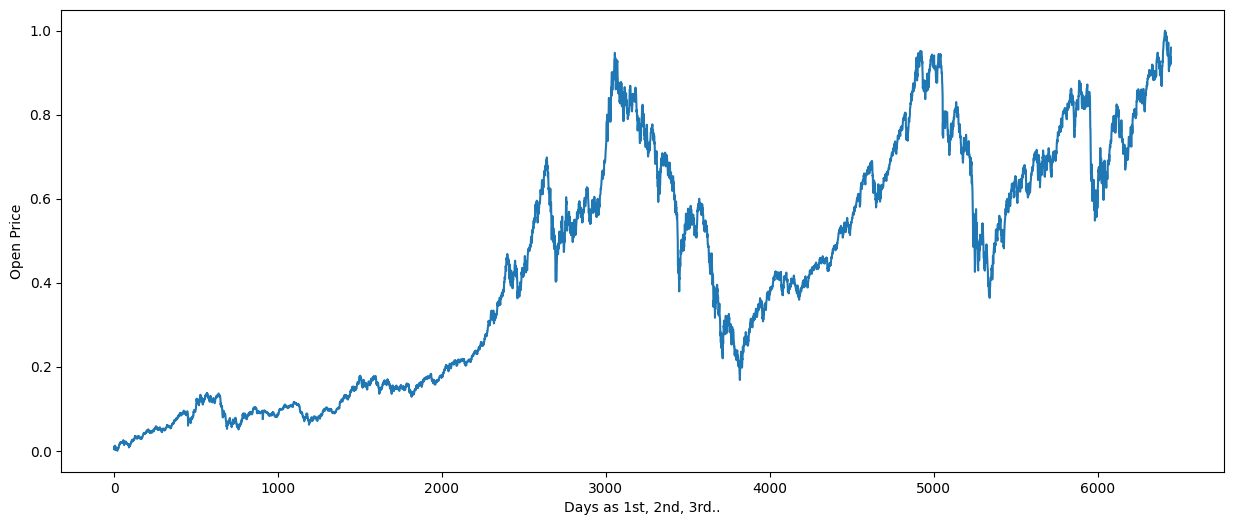

In [22]:
plt.subplots(figsize = (15,6))
plt.plot(dataset_train_scaled)
plt.xlabel("Days as 1st, 2nd, 3rd..")
plt.ylabel("Open Price")
plt.show()

In [23]:
X_train = []
y_train = []

time_step = 50

for i in range(time_step, length_train):
    X_train.append(dataset_train_scaled[i-time_step:i,0])
    y_train.append(dataset_train_scaled[i,0])
    
# convert list to array
X_train, y_train = np.array(X_train), np.array(y_train)

In [24]:
print("Shape of X_train before reshape :",X_train.shape)
print("Shape of y_train before reshape :",y_train.shape)

Shape of X_train before reshape : (6399, 50)
Shape of y_train before reshape : (6399,)


In [25]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
y_train = np.reshape(y_train, (y_train.shape[0],1))

print("Shape of X_train after reshape :",X_train.shape)
print("Shape of y_train after reshape :",y_train.shape)

Shape of X_train after reshape : (6399, 50, 1)
Shape of y_train after reshape : (6399, 1)


In [26]:
X_train[0]


array([[0.00918668],
       [0.00272055],
       [0.00797975],
       [0.00929555],
       [0.01041882],
       [0.01204132],
       [0.00684055],
       [0.0067569 ],
       [0.0039527 ],
       [0.00510652],
       [0.00218547],
       [0.00891316],
       [0.00586598],
       [0.00324501],
       [0.00175793],
       [0.00404697],
       [0.00353579],
       [0.00428331],
       [0.00314277],
       [0.00023368],
       [0.        ],
       [0.00205801],
       [0.00261167],
       [0.00480511],
       [0.00719904],
       [0.00575976],
       [0.00676487],
       [0.00628157],
       [0.00811784],
       [0.01177577],
       [0.0129442 ],
       [0.01505   ],
       [0.01590242],
       [0.01557048],
       [0.01539388],
       [0.01470878],
       [0.01639501],
       [0.01766301],
       [0.01777853],
       [0.0206584 ],
       [0.01903988],
       [0.01956301],
       [0.02009145],
       [0.01917796],
       [0.01941696],
       [0.01847293],
       [0.01877035],
       [0.019

In [27]:
y_train[0]

array([0.01824987])

In [28]:
# importing libraries
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Dropout, Input

# initializing the RNN
regressor = Sequential()

# defining the input shape
regressor.add(Input(shape=(X_train.shape[1], 1)))

# adding first RNN layer and dropout regularization
regressor.add(SimpleRNN(units=50, activation="tanh", return_sequences=True))
regressor.add(Dropout(0.2))

# adding second RNN layer and dropout regularization
regressor.add(SimpleRNN(units=50, activation="tanh", return_sequences=True))
regressor.add(Dropout(0.2))

# adding third RNN layer and dropout regularization
regressor.add(SimpleRNN(units=50, activation="tanh", return_sequences=True))
regressor.add(Dropout(0.2))

# adding fourth RNN layer and dropout regularization
regressor.add(SimpleRNN(units=50))
regressor.add(Dropout(0.2))

# adding the output layer
regressor.add(Dense(units=1))

# compiling RNN
regressor.compile(optimizer="adam", loss="mean_squared_error", metrics=["accuracy"])

# fitting the RNN
history = regressor.fit(X_train, y_train, epochs=50, batch_size=32)


Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.0000e+00 - loss: 0.2450
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 1.1447e-04 - loss: 0.0480
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 1.7236e-04 - loss: 0.0246
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 1.5262e-04 - loss: 0.0155
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 6.3026e-06 - loss: 0.0095
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 3.2137e-04 - loss: 0.0075
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 8.9243e-05 - loss: 0.0065
Epoch 8/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 3.2494e-05 - loss: 0.0048
Epoch 9/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 4.6411e-05 - loss: 0.0042
Epoch 10/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 1.5550e-06 - loss: 0.0036
Epoch 11/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 1.5550e-06 - loss: 0.00

In [29]:
history.history["loss"]

[0.16075389087200165,
 0.03888653218746185,
 0.02151477336883545,
 0.013772095553576946,
 0.009094636887311935,
 0.0072300853207707405,
 0.005891214124858379,
 0.0048088026233017445,
 0.0040651168674230576,
 0.00350114400498569,
 0.0033032812643796206,
 0.0027042790316045284,
 0.0023524623829871416,
 0.0022392093669623137,
 0.0020810728892683983,
 0.0017670009983703494,
 0.0016941031208261847,
 0.001580633339472115,
 0.001614599721506238,
 0.0014907594304531813,
 0.001485213404521346,
 0.0013123436365276575,
 0.0011942265555262566,
 0.0011928582098335028,
 0.0011536949314177036,
 0.001112819998525083,
 0.001085470779798925,
 0.0010951281292364001,
 0.001127485535107553,
 0.0010822959011420608,
 0.001070806523784995,
 0.001051314058713615,
 0.0009818547405302525,
 0.0009571158443577588,
 0.0010207057930529118,
 0.0009775683283805847,
 0.0009951175889000297,
 0.0009808301692828536,
 0.0010629958705976605,
 0.000912790244910866,
 0.0009828900219872594,
 0.0010491665452718735,
 0.000966399

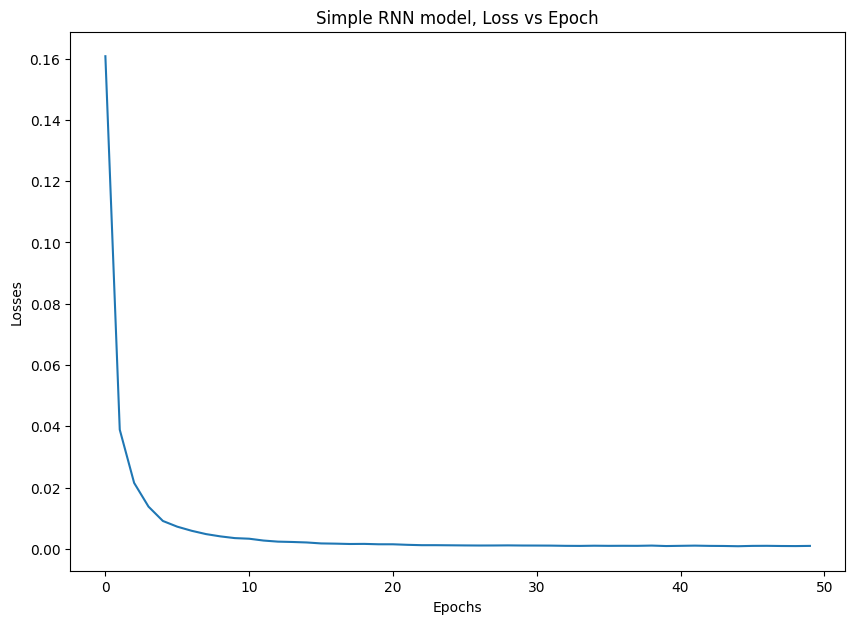

In [30]:
# Plotting Loss vs Epochs
plt.figure(figsize =(10,7))
plt.plot(history.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("Simple RNN model, Loss vs Epoch")
plt.show()

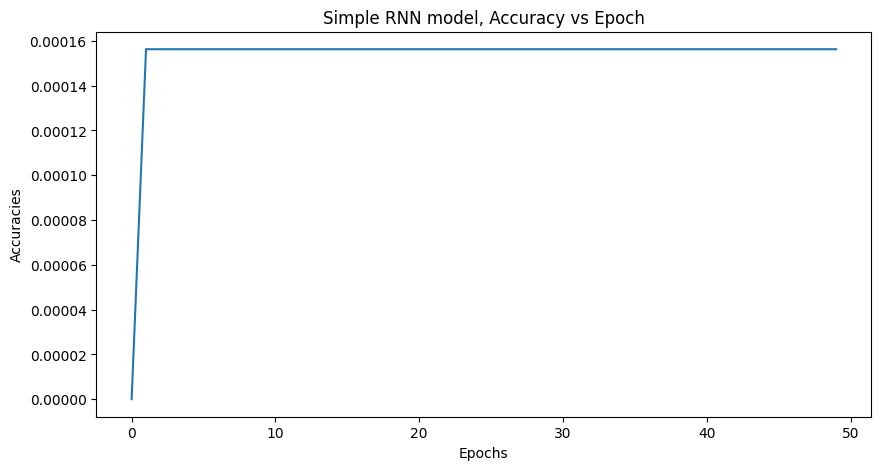

In [31]:
# Plotting Accuracy vs Epochs
plt.figure(figsize =(10,5))
plt.plot(history.history["accuracy"])
plt.xlabel("Epochs")
plt.ylabel("Accuracies")
plt.title("Simple RNN model, Accuracy vs Epoch")
plt.show()

In [32]:
y_pred = regressor.predict(X_train)  # predictions
y_pred = scaler.inverse_transform(y_pred) # scaling back from 0-1 to original
y_pred.shape

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


(6399, 1)

In [33]:
y_train = scaler.inverse_transform(y_train) # scaling back from 0-1 to original
y_train.shape

(6399, 1)

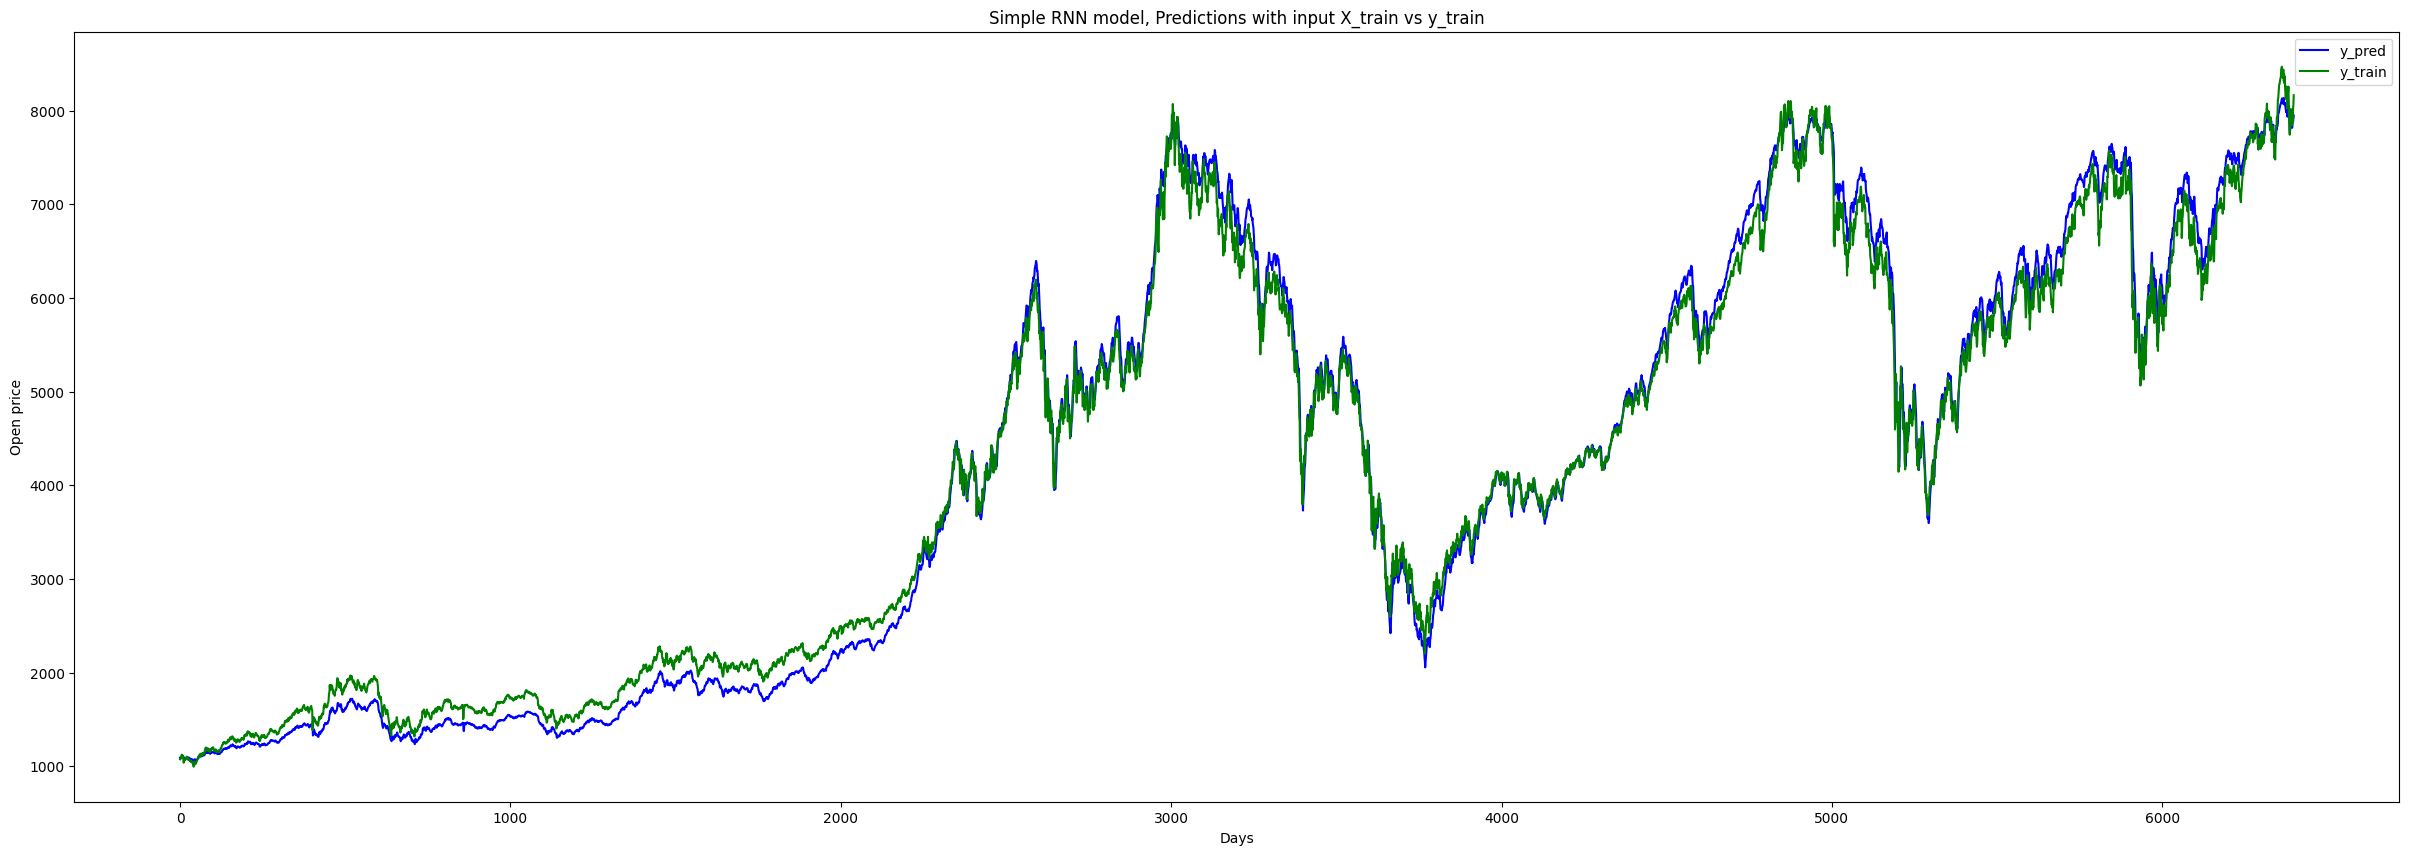

In [34]:
# visualisation
plt.figure(figsize = (30,10))
plt.plot(y_pred, color = "b", label = "y_pred" )
plt.plot(y_train, color = "g", label = "y_train")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Simple RNN model, Predictions with input X_train vs y_train")
plt.legend()
plt.show()

In [35]:
dataset_validation = validation_data.Open.values  # getting "open" column and converting to array
dataset_validation = np.reshape(dataset_validation, (-1,1))  # converting 1D to 2D array
scaled_dataset_validation =  scaler.fit_transform(dataset_validation)  # scaling open values to between 0 and 1
print("Shape of scaled validation dataset :",scaled_dataset_validation.shape)

Shape of scaled validation dataset : (2764, 1)


In [36]:
# Creating X_test and y_test
X_test = []
y_test = []

for i in range(time_step, length_validation):
    X_test.append(scaled_dataset_validation[i-time_step:i,0])
    y_test.append(scaled_dataset_validation[i,0])

In [37]:
# Converting to array
X_test, y_test = np.array(X_test), np.array(y_test)

In [38]:
print("Shape of X_test before reshape :",X_test.shape)
print("Shape of y_test before reshape :",y_test.shape)

Shape of X_test before reshape : (2714, 50)
Shape of y_test before reshape : (2714,)


In [39]:
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))  # reshape to 3D array
y_test = np.reshape(y_test, (-1,1))  # reshape to 2D array

In [40]:
print("Shape of X_test after reshape :",X_test.shape)
print("Shape of y_test after reshape :",y_test.shape)

Shape of X_test after reshape : (2714, 50, 1)
Shape of y_test after reshape : (2714, 1)


In [41]:
# predictions with X_test data
y_pred_of_test = regressor.predict(X_test)
# scaling back from 0-1 to original
y_pred_of_test = scaler.inverse_transform(y_pred_of_test) 
print("Shape of y_pred_of_test :",y_pred_of_test.shape)

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Shape of y_pred_of_test : (2714, 1)


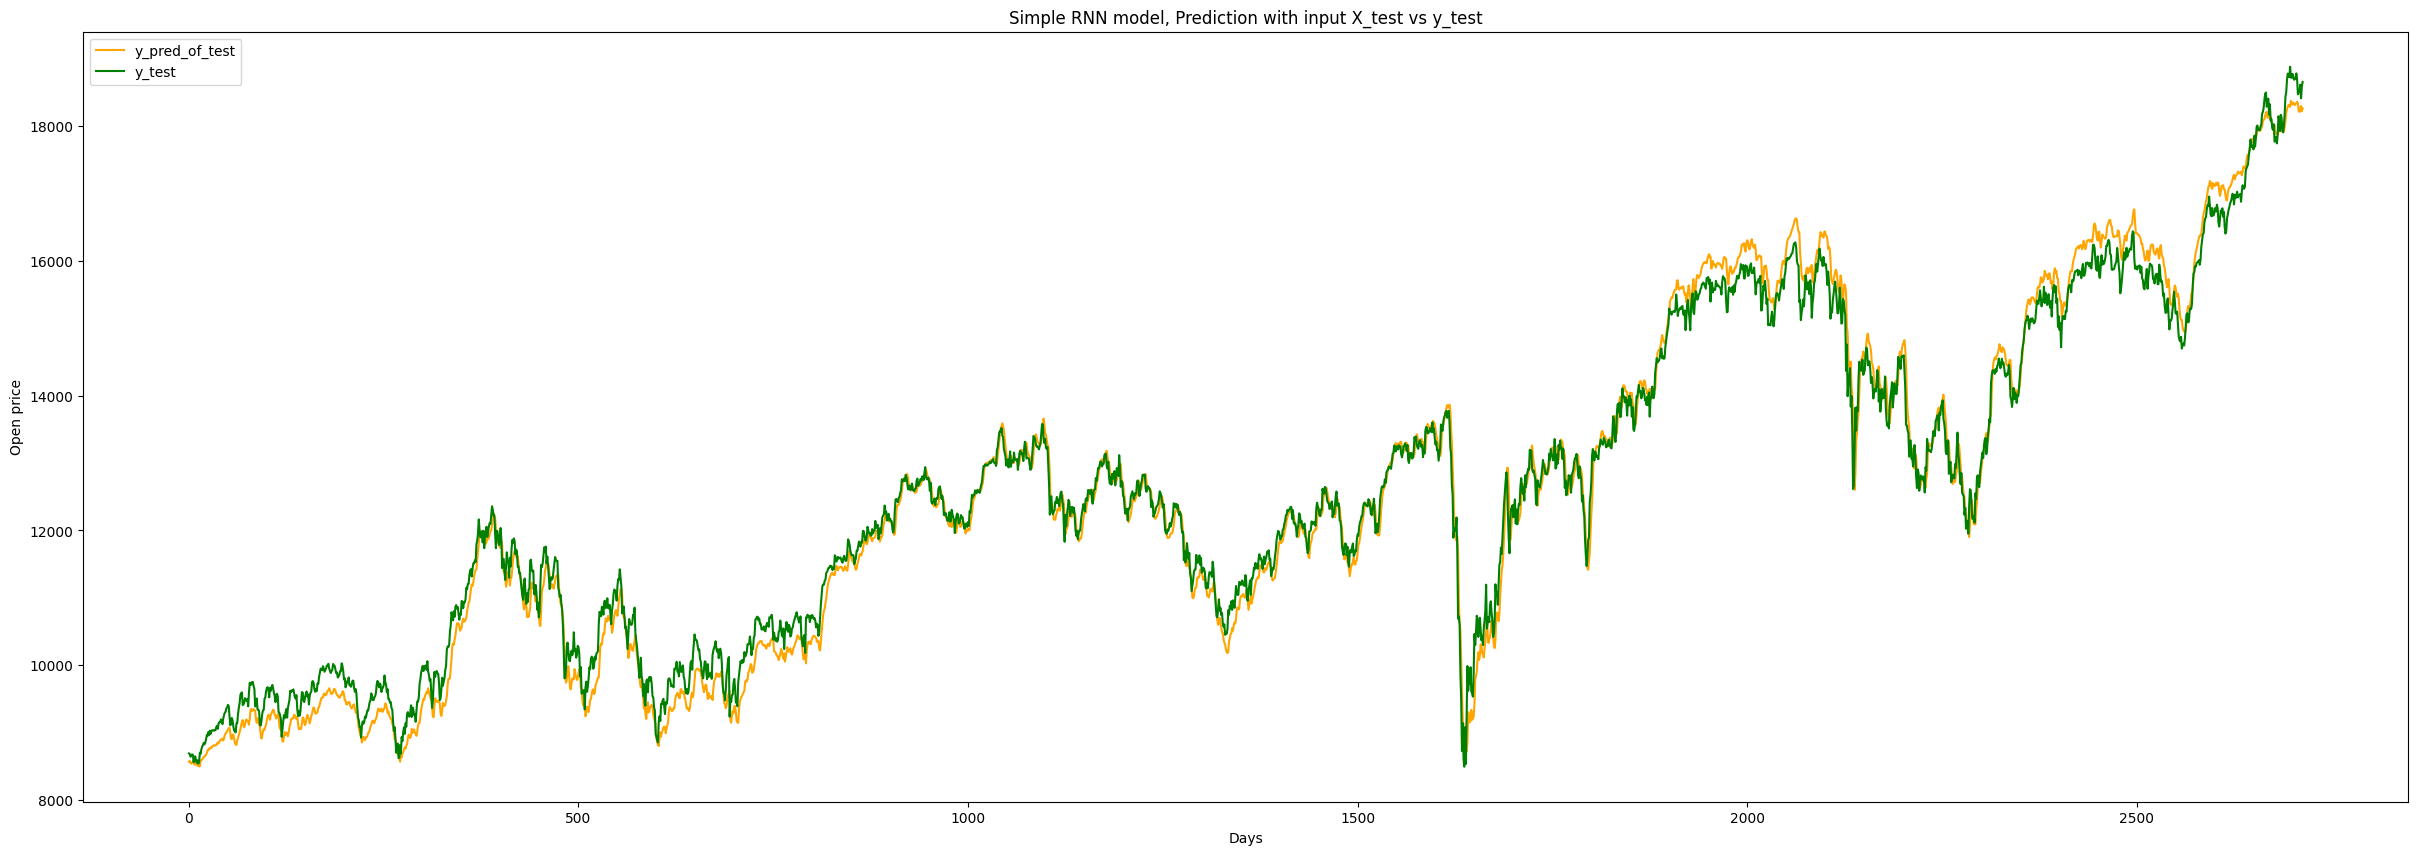

In [42]:
# visualisation
plt.figure(figsize = (30,10))
plt.plot(y_pred_of_test, label = "y_pred_of_test", c = "orange")
plt.plot(scaler.inverse_transform(y_test), label = "y_test", c = "g")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Simple RNN model, Prediction with input X_test vs y_test")
plt.legend()
plt.show()

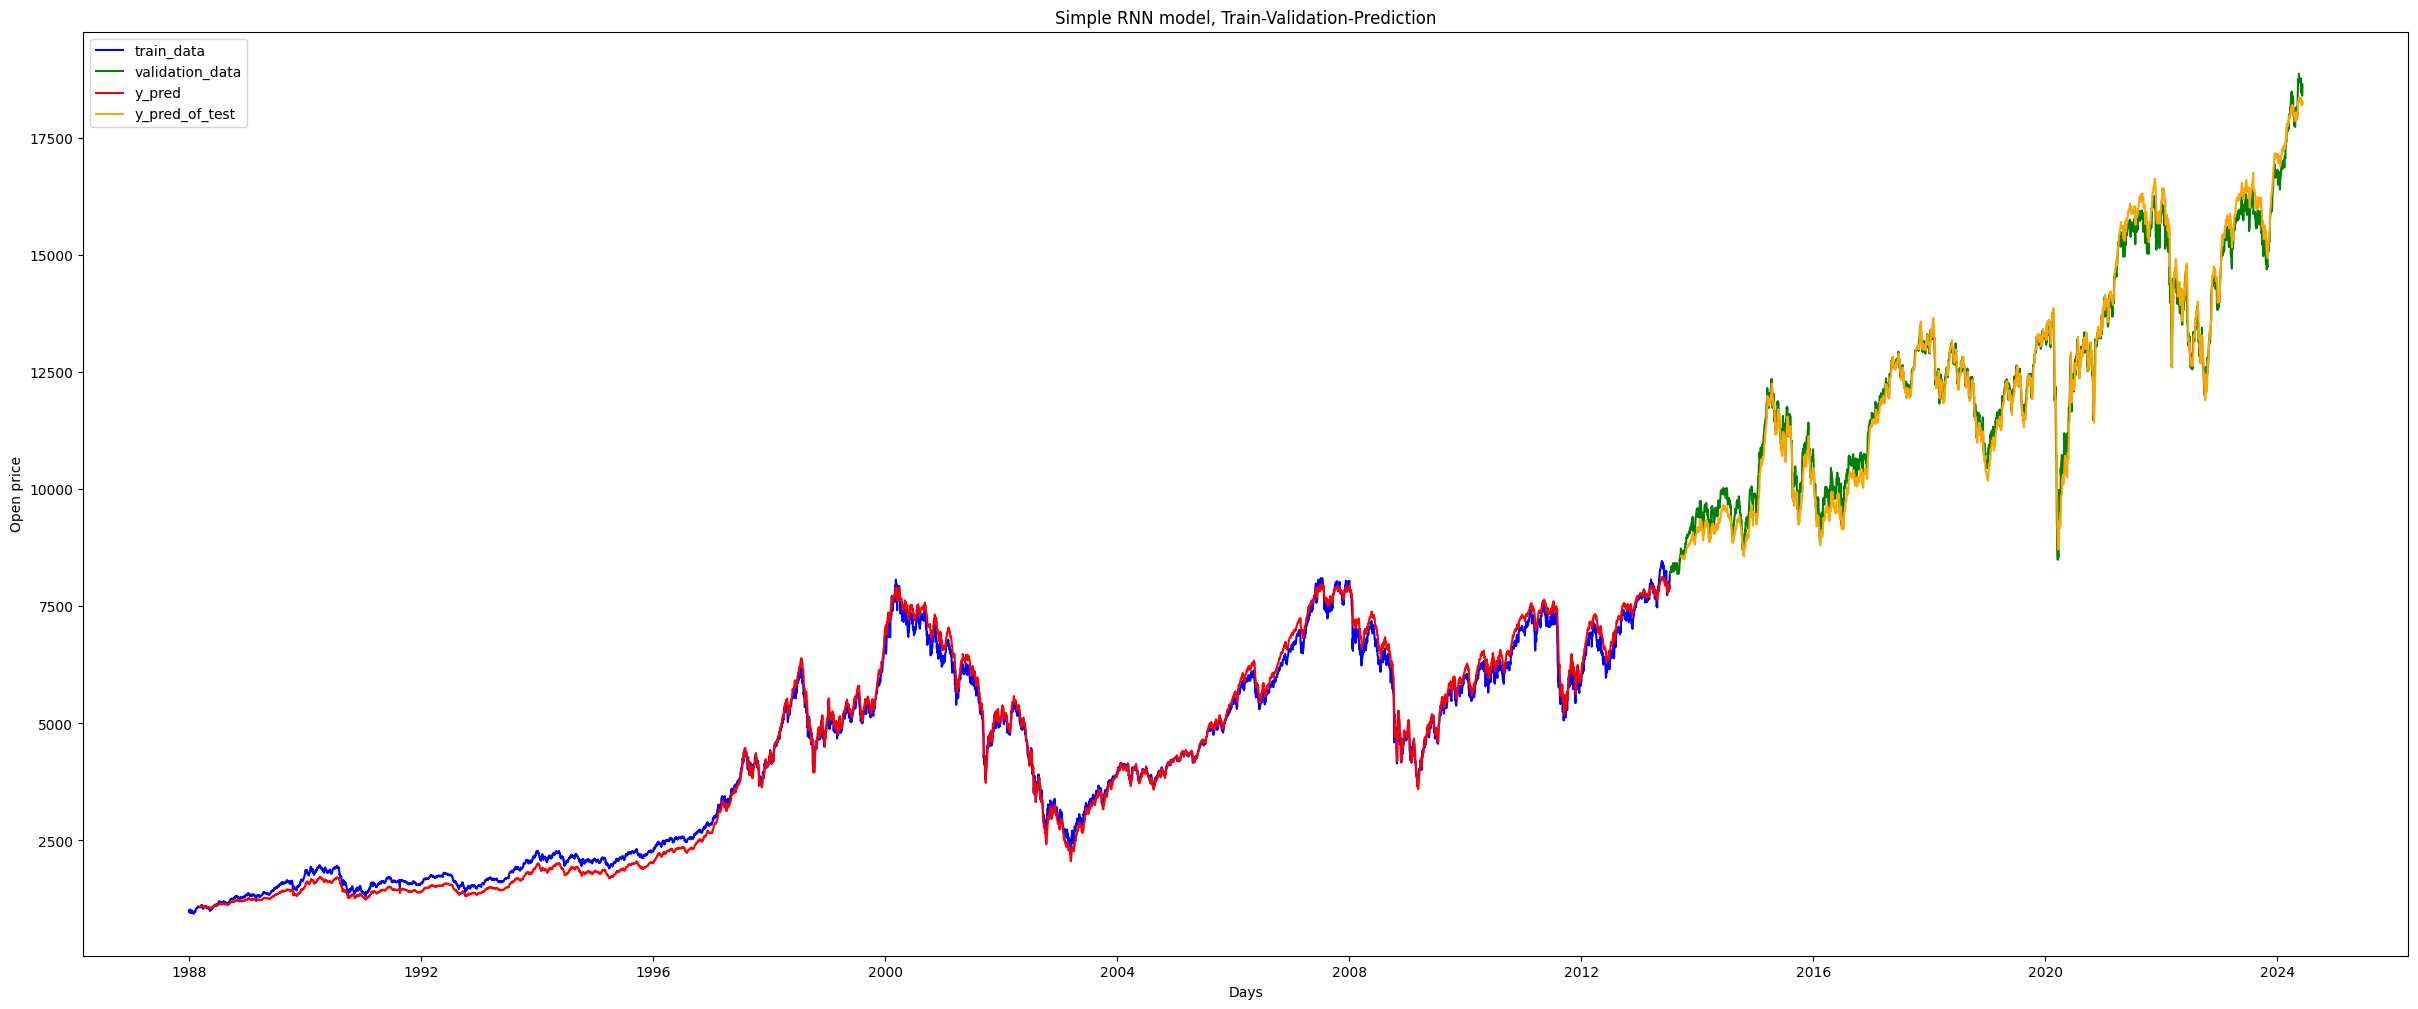

In [43]:
# Visualisation
plt.subplots(figsize =(30,12))
plt.plot(train_data.Date, train_data.Open, label = "train_data", color = "b")
plt.plot(validation_data.Date, validation_data.Open, label = "validation_data", color = "g")
plt.plot(train_data.Date.iloc[time_step:], y_pred, label = "y_pred", color = "r")
plt.plot(validation_data.Date.iloc[time_step:], y_pred_of_test, label = "y_pred_of_test", color = "orange")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Simple RNN model, Train-Validation-Prediction")
plt.legend()
plt.show()

In [44]:
y_train = scaler.fit_transform(y_train)

In [45]:
from keras.layers import LSTM

model_lstm = Sequential()
model_lstm.add(
    LSTM(64,return_sequences=True,input_shape = (X_train.shape[1],1))) #64 lstm neuron block
model_lstm.add(
    LSTM(64, return_sequences= False))
model_lstm.add(Dense(32))
model_lstm.add(Dense(1))
model_lstm.compile(loss = "mean_squared_error", optimizer = "adam", metrics = ["accuracy"])
history2 = model_lstm.fit(X_train, y_train, epochs = 10, batch_size = 10)

Epoch 1/10


/Users/riccardo/Desktop/Github/Bachelor/Bachelor/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


640/640 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 5.4418e-04 - loss: 0.0090
Epoch 2/10
640/640 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 1.8808e-04 - loss: 3.6819e-04
Epoch 3/10
640/640 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 4.2694e-04 - loss: 3.1033e-04
Epoch 4/10
640/640 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 4.1248e-05 - loss: 2.5754e-04
Epoch 5/10
640/640 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 3.3779e-04 - loss: 2.0963e-04
Epoch 6/10
640/640 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 2.8809e-04 - loss: 1.8027e-04
Epoch 7/10
640/640 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 5.2391e-04 - loss: 1.5899e-04
Epoch 8/10
640/640 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 6.4570e-05 - loss: 1.2333e-04
Epoch 9/10
640/640 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 2.6860e-04 - loss: 1.4151e-04
Epoch 10/10
640/640 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 1.0157e-04 - loss: 1.4320e-04


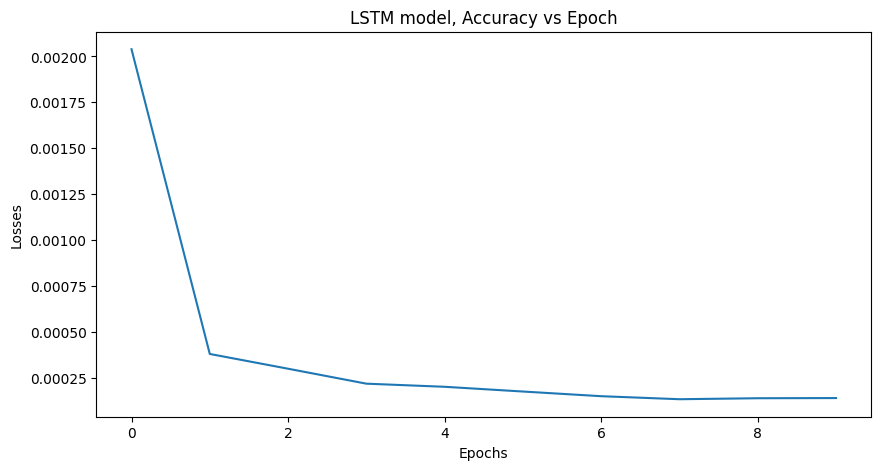

In [46]:
plt.figure(figsize =(10,5))
plt.plot(history2.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("LSTM model, Accuracy vs Epoch")
plt.show()

85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


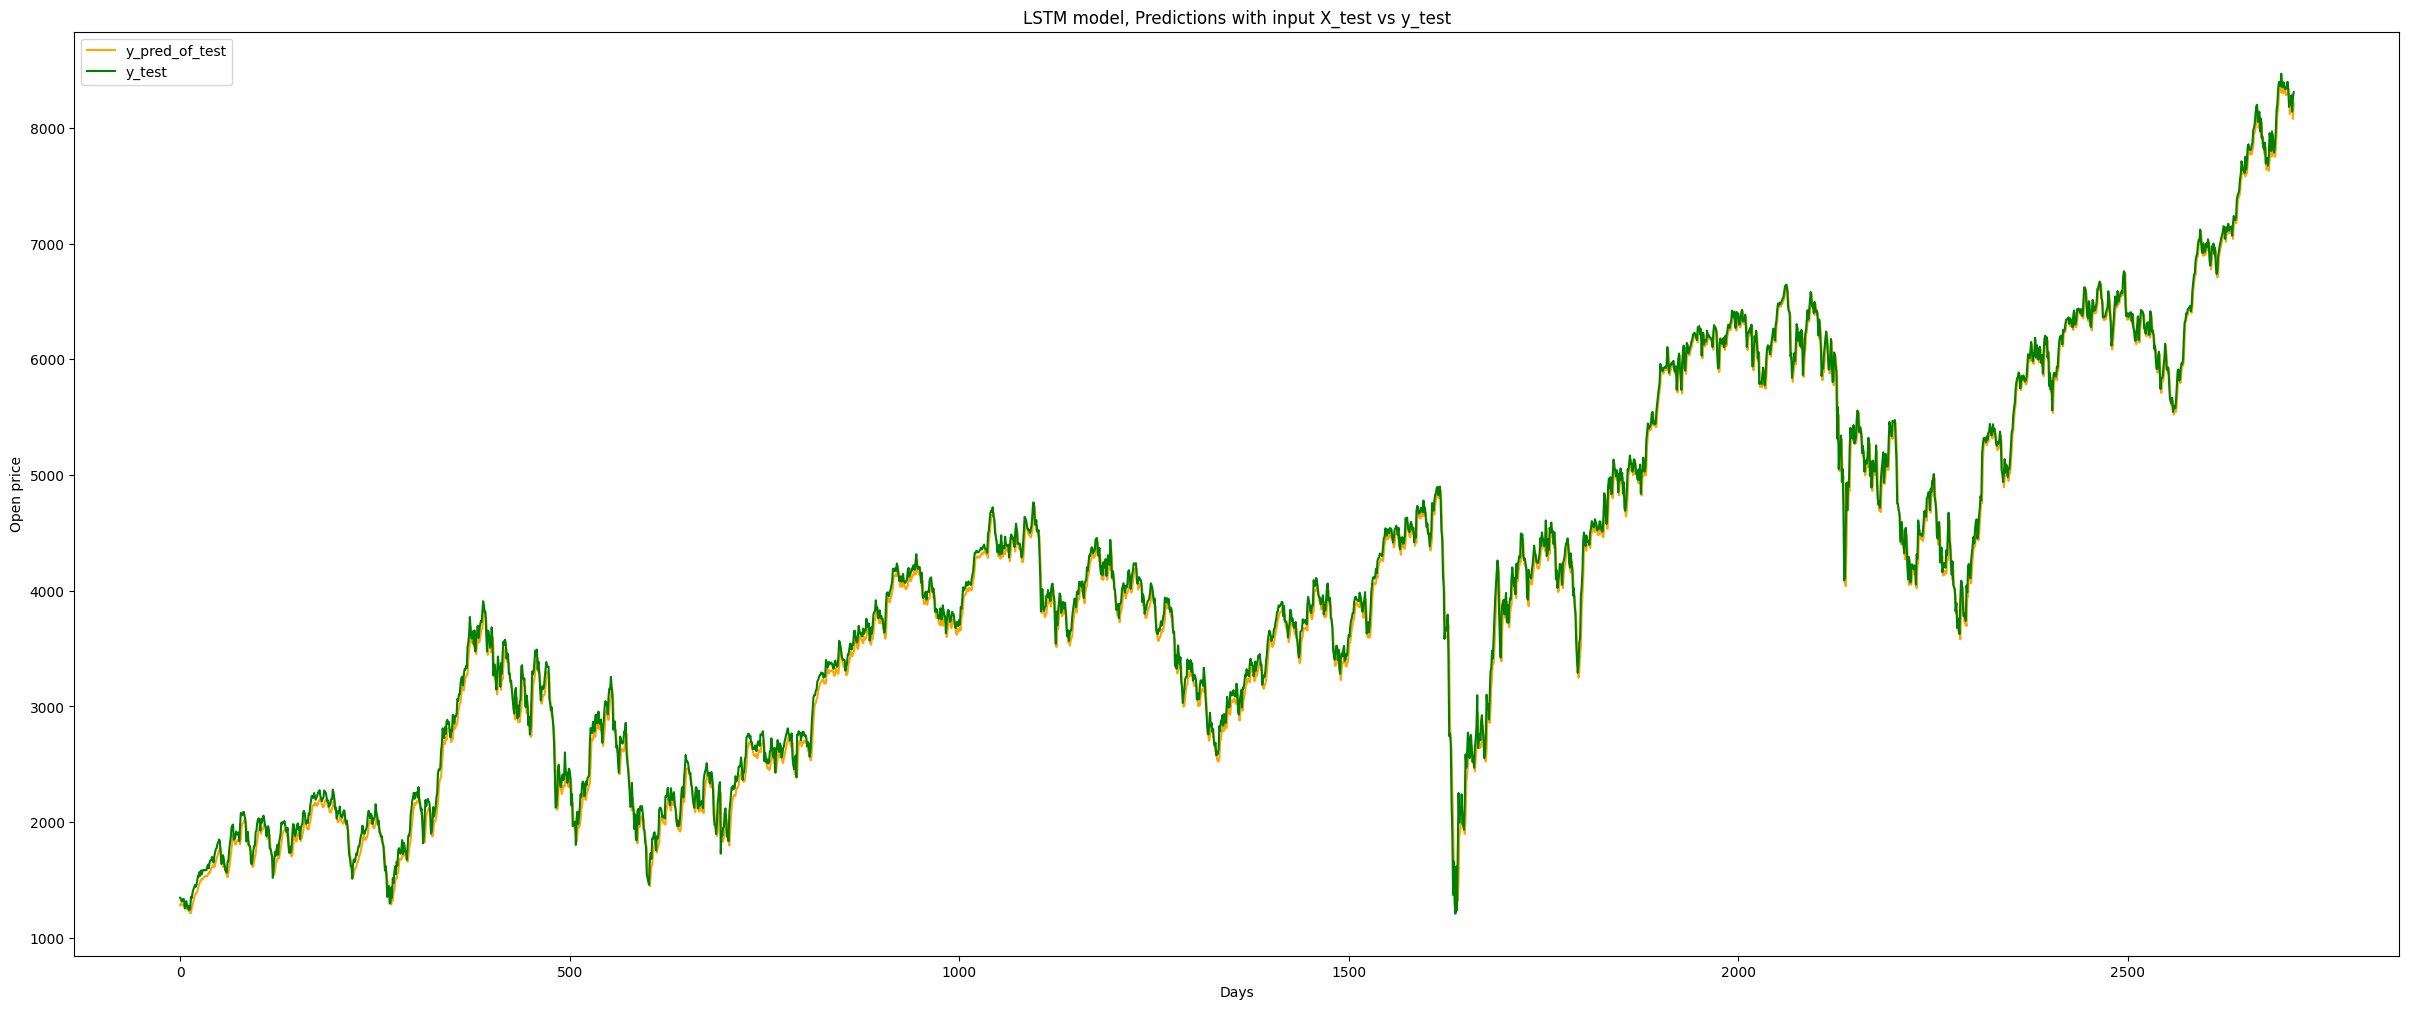

In [47]:
plt.subplots(figsize =(30,12))
plt.plot(scaler.inverse_transform(model_lstm.predict(X_test)), label = "y_pred_of_test", c = "orange" )
plt.plot(scaler.inverse_transform(y_test), label = "y_test", color = "g")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("LSTM model, Predictions with input X_test vs y_test")
plt.legend()
plt.show()

In [48]:
data.iloc[-1]

Date           2024-06-07
Open         18649.080078
High         18649.080078
Low          18424.599609
Close        18557.269531
Adj Close    18557.269531
Volume         61383200.0
Name: 9380, dtype: object

In [49]:
X_input = data.iloc[-time_step:].Open.values               # getting last 50 rows and converting to array
X_input = scaler.fit_transform(X_input.reshape(-1,1))      # converting to 2D array and scaling
X_input = np.reshape(X_input, (1,50,1))                    # reshaping : converting to 3D array
print("Shape of X_input :", X_input.shape)
X_input

Shape of X_input : (1, 50, 1)


array([[[0.56925128],
        [0.65038219],
        [0.66354092],
        [0.47833938],
        [0.5527131 ],
        [0.58390645],
        [0.37416222],
        [0.51051719],
        [0.29983146],
        [0.31533021],
        [0.20048209],
        [0.17556142],
        [0.24993686],
        [0.02286241],
        [0.03287363],
        [0.08514261],
        [0.        ],
        [0.10833833],
        [0.35375322],
        [0.30799403],
        [0.16070524],
        [0.37307125],
        [0.33593163],
        [0.173943  ],
        [0.14260189],
        [0.23142976],
        [0.38456001],
        [0.60890615],
        [0.66858175],
        [0.83462504],
        [0.9106189 ],
        [0.8777195 ],
        [0.86361926],
        [1.        ],
        [0.85784825],
        [0.85510448],
        [0.90657284],
        [0.87403423],
        [0.83078171],
        [0.83528478],
        [0.84894691],
        [0.91265138],
        [0.82657586],
        [0.63988819],
        [0.6660579 ],
        [0

In [50]:
simple_RNN_prediction = scaler.inverse_transform(regressor.predict(X_input))
LSTM_prediction = scaler.inverse_transform(model_lstm.predict(X_input))
print("Simple RNN, Open price prediction for 3/18/2017      :", simple_RNN_prediction[0,0])
print("LSTM prediction, Open price prediction for 3/18/2017 :", LSTM_prediction[0,0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Simple RNN, Open price prediction for 3/18/2017      : 18634.11
LSTM prediction, Open price prediction for 3/18/2017 : 18642.783


In [2]:
import pandas as pd

In [3]:
data = pd.read_csv("data/raw/^GDAXI.csv")
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1987-12-30,1005.190002,1005.190002,1005.190002,1005.190002,1005.190002,0.0
1,1987-12-31,NaN,NaN,NaN,NaN,NaN,NaN
2,1988-01-01,NaN,NaN,NaN,NaN,NaN,NaN
3,1988-01-04,956.489990,956.489990,956.489990,956.489990,956.489990,0.0
4,1988-01-05,996.099976,996.099976,996.099976,996.099976,996.099976,0.0


In [32]:
print(len(data))
X_var = data[["Open","Close"]]
train_slider = 60
validation_slider = 20
n_steps= 50

X_train, y_train = data[["Open","Close"]][:int(len(data)*train_slider/100)], data["Date"][:int(len(data)*train_slider/100)]
X_val, y_val = data[["Open","Close"]][:int(len(data)*validation_slider/100)], data["Date"][:int(len(data)*validation_slider/100)]
print(data.shape,X_train.shape, y_train.shape)
print(data.shape,X_val.shape, y_val.shape)

9381
(9381, 7) (5628, 2) (5628,)
(9381, 7) (1876, 2) (1876,)


In [36]:
y_train = pd.to_datetime(y_train)
y_train.dtype

dtype('<M8[ns]')

In [28]:
X_train

,Open,Close
0,1005.190002,1005.190002
1,NaN,NaN
2,NaN,NaN
3,956.489990,956.489990
4,996.099976,996.099976
...,...,...
5623,5482.990234,5557.089844
5624,5548.770020,5521.970215
5625,5512.899902,5470.330078
5626,5512.169922,5517.350098
